[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tiagodsilva/llm-programs/blob/main/02-reflexion/02-reflexion.ipynb)

In [ ]:
#@title Bootstrap (click to expand)

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Colab — installing dependencies...")
    
    # Fetch pyproject.toml
    !curl -L -o pyproject.toml https://raw.githubusercontent.com/tiagodsilva/llm-programs/main/pyproject.toml
    
    # Install poetry and dependencies
    %pip install uv
    !uv sync

## Connect to the LLM provider

In [2]:
import os
from getpass import getpass


def _set_if_undefined(var: str) -> None:
    if os.environ.get(var):
        return
    os.environ[var] = getpass(var)


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4-turbo-preview")

In [7]:
from langchain_tavily.tavily_search import TavilySearch

# topic in {general, news, finance}
tavily_tool = TavilySearch(max_results=5, topic="general")

## Create input/output templates

In [21]:
from langchain_core.messages import HumanMessage, ToolMessage, AIMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import ValidationError

from pydantic import BaseModel, Field


class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")


class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )


class ResponderWithRetries:
    def __init__(
        self,
        runnable: ChatPromptTemplate,
        validator: ChatPromptTemplate,
        max_attempts: int = 3,
    ):
        self.runnable = runnable
        self.validator = validator

        self.max_attempts = max_attempts

    def respond(self, state: dict) -> dict[str, AIMessage]:
        response = []
        for attempt in range(self.max_attempts):
            response = self.runnable.invoke(
                {"messages": state["messages"]}, {"tags": [f"attempt:{attempt}"]}
            )
            try:
                self.validator.invoke(response)
                return {"messages": response}
            except ValidationError as e:
                state = state + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                        + self.validator.model_dump_json()
                        + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        return {"messages": response}

## Call the LLM for the first response 

In [11]:
import datetime

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are expert researcher.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<system>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)
initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer.",
    function_name=AnswerQuestion.__name__,
) | llm.bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)

In [12]:
example_question = "Why is reflection useful in AI?"
initial = first_responder.respond(
    {"messages": [HumanMessage(content=example_question)]}
)

## Call an LLM to revise the first response

In [29]:
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""


# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: list[str] = Field(
        description="Citations motivating your updated answer."
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm.bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)

In [38]:
import json

revised = revisor.respond(
    {
        "messages": [
            HumanMessage(content=example_question),
            initial["messages"],
            ToolMessage(
                tool_call_id=initial["messages"].tool_calls[0]["id"],
                content=json.dumps(
                    tavily_tool.invoke(
                        {
                            "query": initial["messages"].tool_calls[0]["args"][
                                "search_queries"
                            ][0]
                        }
                    )
                ),
            ),
        ]
    }
)

In [45]:
revised["messages"].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  ReviseAnswer (call_Ga3JNQPD4XRnTeYjZFgCKPd4)
 Call ID: call_Ga3JNQPD4XRnTeYjZFgCKPd4
  Args:
    answer: Reflection in AI enhances its adaptability, learning efficiency, and problem-solving abilities. It enables AI systems to assess and adjust their strategies or behaviors autonomously. Here are key points that underline its utility:

1. **Adaptable to Changes:** Reflective AI systems can adjust to new circumstances without pre-configured solutions, crucial in unpredictable environments [1].
2. **Self-Optimization:** AI can continually improve by analyzing past actions and outcomes, facilitating lifelong learning [2].
3. **Debugging and Fault Correction:** By examining its processes, AI can identify errors or inefficiencies for rectification, improving reliability and ease of maintenance [3].
4. **Personalized Interactions:** AI that consider user feedback or behavior can tailor experiences, 

## Create a graph to represent this behavior

In [40]:
from langchain_core.tools import StructuredTool

from langgraph.prebuilt import ToolNode


def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])

# We first define the graph's nodes (callable tools)
tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

In [ ]:
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


MAX_ITERATIONS = 5
builder = StateGraph(State)

# We first provide a draft of the answer
builder.add_node("draft", first_responder.respond)

# Then, we use Tavily to search for references
builder.add_node("execute_tools", tool_node)

# We revise the initial answer based on the provided references
builder.add_node("revise", revisor.respond)

# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:


def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i


def event_loop(state: list):
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state["messages"])
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop, ["execute_tools", END])
builder.add_edge(START, "draft")
graph = builder.compile()

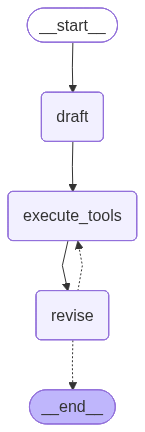

In [42]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [43]:
events = graph.stream(
    {"messages": [("user", "How should we handle the climate crisis?")]},
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    step["messages"][-1].pretty_print()

Step 0
================================ Human Message =================================

How should we handle the climate crisis?
Step 1
================================== Ai Message ==================================
Tool Calls:
  AnswerQuestion (call_iaIbia8mZ7Z5bmcXOZmyjrnj)
 Call ID: call_iaIbia8mZ7Z5bmcXOZmyjrnj
  Args:
    answer: Addressing the climate crisis requires a multifaceted and holistic approach that encompasses immediate and long-term strategies. Initially, a rapid shift towards renewable energy sources such as solar, wind, and hydroelectric power is crucial to reduce greenhouse gas emissions. This transition also involves phasing out fossil fuels, improving energy efficiency, and investing in green technology. Governments and industries need to enforce stricter environmental regulations and support sustainable practices through policies and incentives. 

Next, protecting and restoring ecosystems can effectively sequester carbon and preserve biodiversity. Reforestation